In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest_xray/pred/PNEUMONIA/PNEUMONIA_2.jpeg
/kaggle/input/chest_xray/pred/PNEUMONIA/PNEUMONIA_3.jpeg
/kaggle/input/chest_xray/pred/PNEUMONIA/person2_bacteria_4.jpeg
/kaggle/input/chest_xray/pred/PNEUMONIA/PNEUMONIA_4.jpeg
/kaggle/input/chest_xray/pred/PNEUMONIA/PNEUMONIA_1.jpeg
/kaggle/input/chest_xray/pred/NORMAL/NORMAL_4.jpeg
/kaggle/input/chest_xray/pred/NORMAL/NORMAL_2.jpeg
/kaggle/input/chest_xray/pred/NORMAL/NORMAL_3.jpeg
/kaggle/input/chest_xray/pred/NORMAL/NORMAL_1.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-9364007-0003.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0001.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/VIRUS-9476607-0001.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/VIRUS-2831144-0001.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-7720431-0003.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-1514320-0002.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/BACTERIA-6950003-0003.jpeg
/kaggle/input/chest_xray/test/PNEUMONIA/V

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tqdm import tqdm
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_dir = '/kaggle/input/chest_xray/train/'
test_dir = '/kaggle/input/chest_xray/test/'
val_dir = '/kaggle/input/chest_xray/pred/'
IMG_SIZE = (224,224)

In [4]:
code = {'NORMAL':0 ,'PNEUMONIA':1} #dictionary

X_val = []
y_val = []

for folder in  os.listdir(val_dir) :
    files = gb.glob(pathname=str(val_dir + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(val_dir + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (IMG_SIZE))
        X_val.append(list(image_array))
        y_val.append(code[folder])

100%|██████████| 4/4 [00:00<00:00, 27.30it/s]


In [5]:
X_test = []
y_test = []

for folder in  os.listdir(test_dir) :
    files = gb.glob(pathname=str(test_dir + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(test_dir + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (IMG_SIZE))
        X_test.append(list(image_array))
        y_test.append(code[folder])

100%|██████████| 234/234 [00:07<00:00, 30.89it/s]


In [6]:
X_train = []
y_train = []

for folder in  os.listdir(train_dir) :
    files = gb.glob(pathname=str(train_dir + '//' + folder + '/*.jpg')) + gb.glob(pathname=str(train_dir + '//' + folder + '/*.jpeg'))
    for file in tqdm(files):
        image = cv2.imread(file)
        image_array = cv2.resize(image , (IMG_SIZE))
        X_train.append(list(image_array))
        y_train.append(code[folder])

100%|██████████| 3432/3432 [01:58<00:00, 28.89it/s]


In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (7315, 224, 224, 3)
y_train (7315,)
X_test (620, 224, 224, 3)
y_test (620,)


In [9]:
#normalize
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

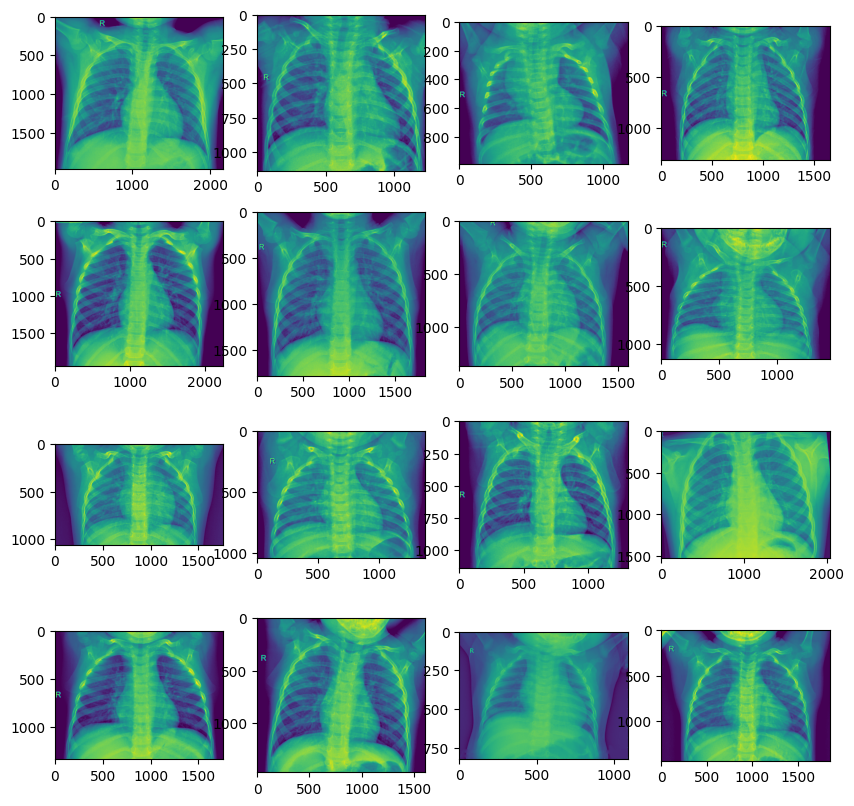

In [10]:
import matplotlib.pyplot as plt

def visualize_images(folder_path):
    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 4

    # Get a list of image file names in the folder
    images = os.listdir(folder_path)

    # Visualize the images
    for i in range(1, columns * rows + 1):
        image_path = os.path.join(folder_path, images[i])
        img = plt.imread(image_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

    plt.show()
    
visualize_images('/kaggle/input/chest_xray/train/NORMAL')

In [11]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import EarlyStopping

In [12]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)

# Add custom layers for classification
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               5

In [13]:
import tensorflow as tf
metrics = [
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()]

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    if epoch > 10:
        lr *= 1e-1
    return lr

# Use the LearningRateScheduler callback during model training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    LearningRateScheduler(lr_schedule)
]

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Train the model
history = model.fit(X_train, y_train.astype('float32'), epochs=50, batch_size=32, validation_data=(X_val,y_val.astype('float32')), callbacks=callbacks)

Epoch 1/50
229/229 [==============================] - 48s 121ms/step - loss: 0.9218 - accuracy: 0.8891 - recall: 0.8905 - precision: 0.8996 - false_negatives: 425.0000 - false_positives: 386.0000 - true_negatives: 3046.0000 - true_positives: 3458.0000 - f1_score: 0.6948 - val_loss: 0.0463 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 0.0000e+00 - val_true_negatives: 4.0000 - val_true_positives: 5.0000 - val_f1_score: 0.7143 - lr: 0.0010
Epoch 2/50
229/229 [==============================] - 22s 97ms/step - loss: 0.1120 - accuracy: 0.9604 - recall: 0.9598 - precision: 0.9653 - false_negatives: 156.0000 - false_positives: 134.0000 - true_negatives: 3298.0000 - true_positives: 3727.0000 - f1_score: 0.6935 - val_loss: 0.1775 - val_accuracy: 0.8889 - val_recall: 1.0000 - val_precision: 0.8333 - val_false_negatives: 0.0000e+00 - val_false_positives: 1.0000 - val_true_negatives: 3.0000 - val_true_positives: 5.0000 -

In [16]:
model.evaluate(X_test, y_test.astype('float32'))

20/20 [==============================] - 4s 179ms/step - loss: 0.1011 - accuracy: 0.9758 - recall: 0.9922 - precision: 0.9696 - false_negatives: 3.0000 - false_positives: 12.0000 - true_negatives: 222.0000 - true_positives: 383.0000 - f1_score: 0.7682


[0.10111362487077713,
 0.975806474685669,
 0.9922279715538025,
 0.9696202278137207,
 3.0,
 12.0,
 222.0,
 383.0,
 array([0.7681592], dtype=float32)]

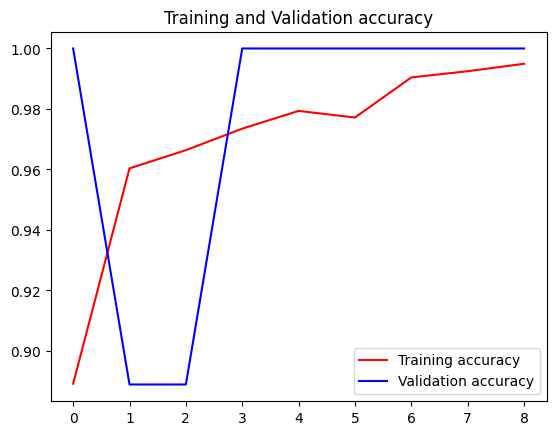

<Figure size 640x480 with 0 Axes>

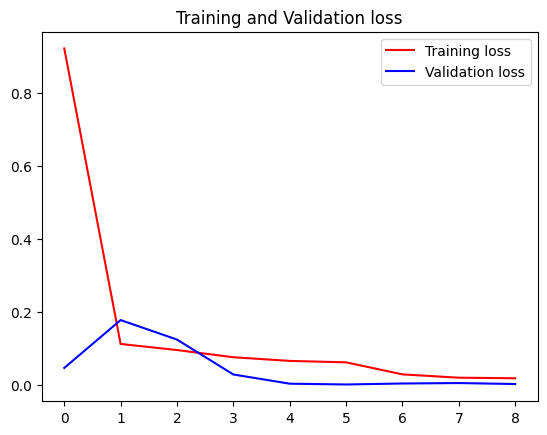

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()